Нейронный перенос стиля с Pytorch
============================
**Aвтор**: `Alexis Jacq <https://alexis-jacq.github.io>` <br />
**Адаптивный перевод**: `Zueva Nadya <https://github.com/nestyme>` <br />
Введение
------------

В этом ноутбуке объясняется и показывается, как работает алгоритм переноса стиля 

`Neural-Style <https://arxiv.org/abs/1508.06576>` 

Леона А. Гатиса, Александра С. Эккера и Маттиаса Бетге.


**Нейронный перенос стиля** -- это алгоритм, который принимает контент-изображение (например, черепаху), стиль-изображение (например, картинку известного художника) и возвращает изображение, которое будто бы нарисовано тем художником:



**Как это работает?**

Всего есть три картинки: вход, стиль и контент. 
Определим два расстояния: 
- $D_S$ - оно определяет на сколько разные стили у двух произвольных картинок.
- $D_C$ - оно определяет на сколько разнится контент у двух произвольных картинок.

задача сети - минимизировать $D_S$ от входной картинки до стиля и $D_C$ от входной картиники до контента.<br />
В качестве входа обычно берется зашумленная к
артинка контента.


Это все что нам понадобится:

In [2]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

     |████████████████████████████████| 5.7MB 7.8MB/s 
     |████████████████████████████████| 112kB 47.2MB/s 
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35416 sha256=3a07c699f391ba6a13f51ac8e0f87dea6fbc027e873377e84a7f7e882cee0e78
  Stored in directory: /root/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built olefile
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [300]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [227]:
!ls /content/drive/MyDrive/DL_style_transfer/style_transfer/images

dancing.jpg  lisa.jpg  picasso.jpg  picca.jpg


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Загрузка изображений**

# Новый раздел

Нам понадобятся картинки стиля и контента, так что загрузим их.<br />
Чтобы упростить реализацию, начнем с контента и стиля одного размера. Затем мы масштабируем их до требуемых размеров выходного изображения.

Примеры изображений лежат в папке `Images` на гуглдиске

Вы можете добавить туда свои собственные изображения -- главное, чтобы они были одного размера

In [301]:
imsize = 128  

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [303]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

path = r"/content/drive/MyDrive/DL_style_transfer/style_transfer/images/"

style_img = image_loader(path + "picasso.jpg")# as well as here
style_img2 = image_loader(path + "picca.jpg")
content_img = image_loader(path + "lisa.jpg")#измените путь на тот который у вас.

Выведем то, что было загружено

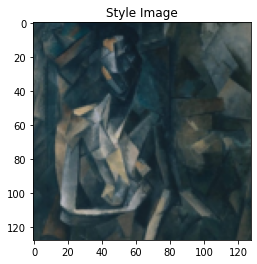

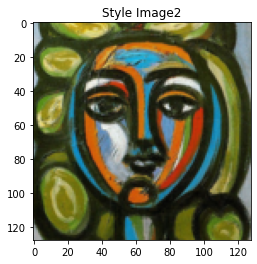

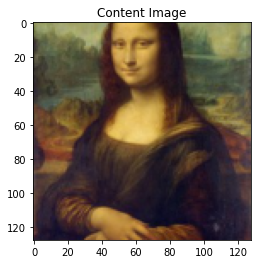

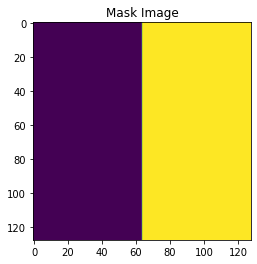

In [304]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


# отрисовка

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(style_img2, title='Style Image2')

plt.figure()
imshow(content_img, title='Content Image')



Теперь нужно создать функции, которые будут вычислять расстояния ( $D_C$ и $D_S$). <br />
Они будут выполенены в виде слоев, чтобы брать по ним автоградиент.

$D_S$ - средняя квадратичная ощибка input'а и target'а

In [5]:
class ContentLoss(nn.Module):

        def __init__(self, target):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

Матрица грама позволяет учесть не только сами значения feature map'а, но и кореляцию фич друг с другом. <br /> Это нужно для того, чтобы сделать акцент на встречаемость фич с друг другом, а не на их геометрическом положении. <br />
Полное понимание этого момента можно получить с помощью [этого](https://arxiv.org/pdf/1508.06576.pdf)  и [этого](https://m.habr.com/company/mailru/blog/306916/).

Таким образом:

$D_S$  = $\sum$($G_{ij}$($img_1$) - $G_{ij}$($img_2$)$)^{2}$

Сначала задаем спрособ подсчета матрицы грама: Это просто тензорное тензорное произведение вектора выхода уровня самого на себя.<br /> Однка наш выход - не вектор. В этом случае операция тоже возможна,<br /> но мы получим тензор третьего ранга. Поэтому перед перемножением выход нужно привести к форме вектора.<br />

In [6]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

Матрица грама готова, теперь нужно лишь реализовать MSE

In [298]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

In [282]:
class StyleLoss_modifided(nn.Module):
        def __init__(self, target_feature, in_mask = mask):
            super(StyleLoss_modifided, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something
            self.mask = in_mask.resize(1,1,imsize,imsize).float()

        def forward(self, input):
            local_mask = F.interpolate(self.mask, input.shape[2:])
            G = gram_matrix(input*local_mask)
            self.loss = F.mse_loss(G, self.target)
            return input

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Если мы хотим изпользовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.


In [8]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [261]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

Теперь соберем это все в одну функцию, которая отдаст на выходе модель и две функции потерь 

Определим после каких уровней мы будем счиатать ошибки стиля, а после каких ошибки контента

In [146]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_layers_default2 = [ 'conv_4', 'conv_5']

Определим предобученную модель

In [11]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [309]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, style_img2, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default, 
                                   style_layers2=style_layers_default2, with_mask=False):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []
        style_losses2 = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).detach()
                if with_mask:
                    style_loss = StyleLoss_modifided(target_feature)
                    
                else:
                    style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)
            if name in style_layers2:
                # add style loss:
                target_feature = model(style_img2).detach()
                if with_mask:
                    style_loss2 = StyleLoss_modifided(target_feature, 1 - mask)
                else:
                    style_loss2 = StyleLoss(target_feature)
                model.add_module("style_loss2_{}".format(i), style_loss2)
                style_losses2.append(style_loss2)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss) or isinstance(model[i], StyleLoss_modifided):
                break

        model = model[:(i + 1)]
        
        return model, style_losses, style_losses2, content_losses

In [13]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

Дальше стандартный цикл обучения, но что это за closure?<br /> Это функция, которая вызывается во время каждого прохода, чтобы пересчитать loss. Без нее ничего не получется так как у нас своя функция ошибки

In [312]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, style_img2, input_img, num_steps=500,
                        style_weight=np.array([0.3, 0.7])*100000, content_weight=1, with_mask = False):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, style_losses2, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, style_img2, content_img, with_mask = with_mask)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                style_score2 = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for sl2 in style_losses2:
                    style_score2 += sl2.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_score *= style_weight[0]
                style_score2 *= style_weight[1]
                content_score *= content_weight

                loss = style_score + style_score2 + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Style Loss2 : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), style_score2.item(), content_score.item()))
                    
                    print()


                return style_score + style_score2 + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)
        
        return input_img

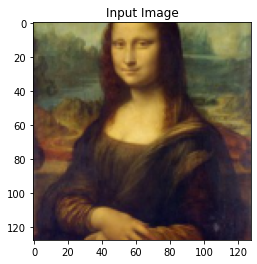

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 458.893524 Style Loss2 : 227.504471 Content Loss: 19.065674

run [100]:
Style Loss : 452.749725 Style Loss2 : 220.794479 Content Loss: 18.918621

run [150]:
Style Loss : 451.310333 Style Loss2 : 217.704849 Content Loss: 18.582634

run [200]:
Style Loss : 450.143951 Style Loss2 : 216.955566 Content Loss: 18.363731

run [250]:
Style Loss : 449.218048 Style Loss2 : 216.886169 Content Loss: 18.183271

run [300]:
Style Loss : 449.699188 Style Loss2 : 215.812912 Content Loss: 18.104811



In [315]:
# Запустм сеть с двумя филтрами и без маски
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, style_img2, input_img, 300, with_mask = False) 

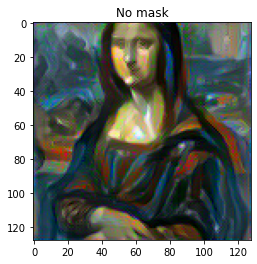

In [317]:
plt.figure()
imshow(output, title='No mask')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


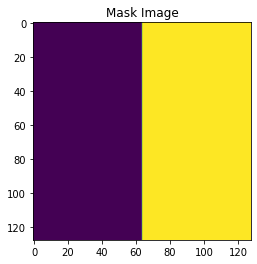

In [320]:
# Запустим сеть с двумя фильтрами и с маской из двух половин:
tmp = np.linspace(0,1, 128).reshape(-1,128) * np.ones(128).reshape(128, -1)
tmp = tmp > 0.5
mask = torch.Tensor(tmp)
mask = mask.resize(1,1,128,128).float()
imshow(mask, title='Mask Image')

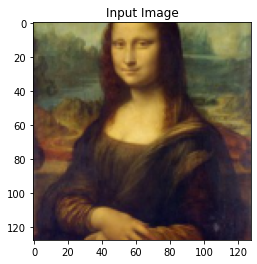

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Optimizing..
run [50]:
Style Loss : 8.201818 Style Loss2 : 29.423367 Content Loss: 37.991257

run [100]:
Style Loss : 3.655642 Style Loss2 : 11.992111 Content Loss: 37.834122

run [150]:
Style Loss : 2.588457 Style Loss2 : 9.072400 Content Loss: 36.730751

run [200]:
Style Loss : 2.413074 Style Loss2 : 7.347556 Content Loss: 36.042812

run [250]:
Style Loss : 2.313734 Style Loss2 : 7.016686 Content Loss: 35.848080

run [300]:
Style Loss : 2.747133 Style Loss2 : 8.427605 Content Loss: 36.789288



In [321]:
# Запустм сеть с двумя фильтрами и с маской из двух половин:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, style_img2, input_img, 300, with_mask = True) 

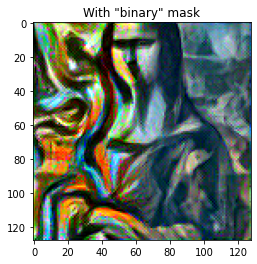

In [322]:
plt.figure()
imshow(output, title='With "binary" mask')

plt.ioff()
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


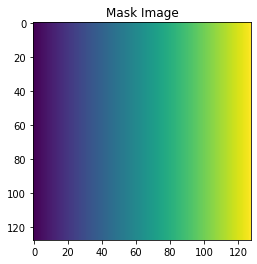

In [323]:
# Запустим сеть с двумя фильтрами и с градиентной маской:
tmp = np.linspace(0,1, 128).reshape(-1,128) * np.ones(128).reshape(128, -1)
mask = torch.Tensor(tmp)
mask = mask.resize(1,1,128,128).float()
imshow(mask, title='Mask Image')

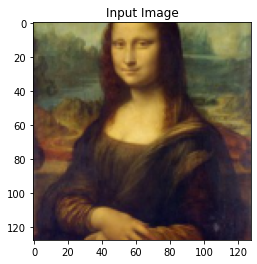

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Optimizing..
run [50]:
Style Loss : 10.944490 Style Loss2 : 92.879349 Content Loss: 179.265137

run [100]:
Style Loss : 5.568890 Style Loss2 : 47.867649 Content Loss: 163.282623



In [330]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, style_img2, input_img, 120, content_weight =3, with_mask = True) 

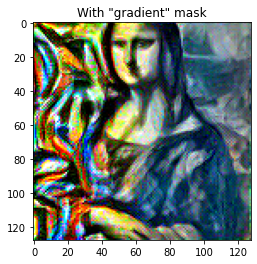

In [331]:
plt.figure()
imshow(output, title='With "gradient" mask')

plt.ioff()
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


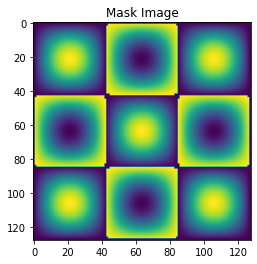

In [344]:
tmp = np.sin(np.linspace(0,1, 128) * np.pi*3).reshape(-1,128) * np.sin(np.linspace(0,1, 128) * np.pi*3).reshape(-1,128).reshape(128, -1)
mask = torch.Tensor(tmp)
mask = mask.resize(1,1,128,128).float()
imshow(mask, title='Mask Image')

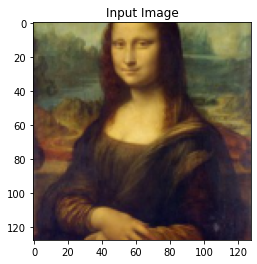

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Optimizing..
run [50]:
Style Loss : 19.797523 Style Loss2 : 28.886715 Content Loss: 40.276024

run [100]:
Style Loss : 13.194685 Style Loss2 : 14.920543 Content Loss: 38.341625

run [150]:
Style Loss : 10.164198 Style Loss2 : 12.157514 Content Loss: 37.342705

run [200]:
Style Loss : 8.351835 Style Loss2 : 11.274514 Content Loss: 36.995136

run [250]:
Style Loss : 7.726463 Style Loss2 : 10.682354 Content Loss: 36.575531

run [300]:
Style Loss : 7.584049 Style Loss2 : 10.359085 Content Loss: 36.231544



In [339]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, style_img2, input_img, 300, content_weight =3, with_mask = True) 

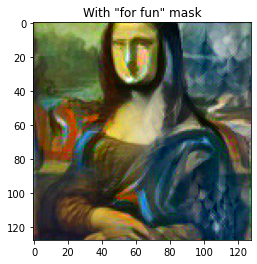

In [340]:
plt.figure()
imshow(output, title='With "for fun" mask')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


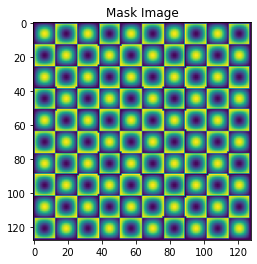

In [355]:
tmp = np.sin(np.linspace(0,1, 128) * np.pi*10).reshape(-1,128) * np.sin(np.linspace(0,1, 128) * np.pi*10).reshape(-1,128).reshape(128, -1)
mask = torch.Tensor(tmp)
mask = mask.resize(1,1,128,128).float()
imshow(mask, title='Mask Image')

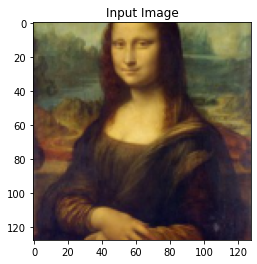

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Optimizing..
run [50]:
Style Loss : 18.400543 Style Loss2 : 26.389725 Content Loss: 49.696621

run [100]:
Style Loss : 12.022419 Style Loss2 : 14.766441 Content Loss: 45.826416

run [150]:
Style Loss : 9.092434 Style Loss2 : 12.442865 Content Loss: 44.009178

run [200]:
Style Loss : 7.747982 Style Loss2 : 11.685283 Content Loss: 43.196552

run [250]:
Style Loss : 7.393691 Style Loss2 : 11.207711 Content Loss: 42.606602

run [300]:
Style Loss : 7.442006 Style Loss2 : 11.262341 Content Loss: 42.482742



In [356]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, style_img2, input_img, 300, content_weight =3, with_mask = True) 

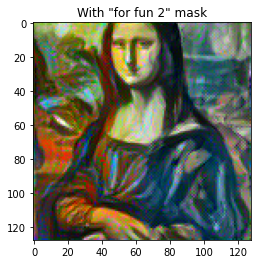

In [357]:
plt.figure()
imshow(output, title='With "for fun 2" mask')

plt.ioff()
plt.show()


Снизу я просто оставил красивые картинки, которые получались во время отладки :)



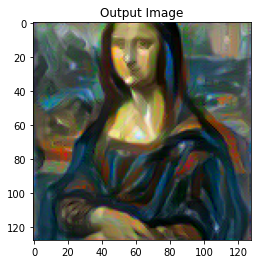

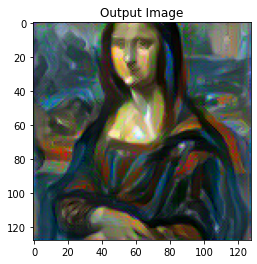

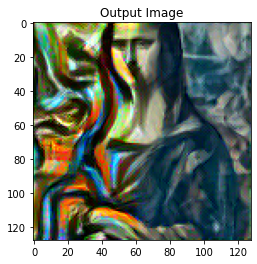

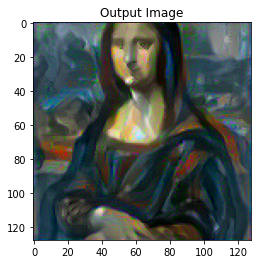